In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Step1： 读出来所有基金的数据

In [2]:
import qlib
from qlib.data import D

qlib.init(provider_uri="~/.qlib/qlib_data/cn_fund_data")
df = D.features(D.instruments(market="all"), ["$DWJZ", "$LJJZ"], freq="day")

[57173:MainThread](2021-08-08 23:38:39,309) INFO - qlib.Initialization - [config.py:276] - default_conf: client.
[57173:MainThread](2021-08-08 23:38:39,311) WARNING - qlib.Initialization - [config.py:291] - redis connection failed(host=127.0.0.1 port=6379), cache will not be used!
[57173:MainThread](2021-08-08 23:38:39,447) INFO - qlib.Initialization - [__init__.py:46] - qlib successfully initialized based on client settings.
[57173:MainThread](2021-08-08 23:38:39,447) INFO - qlib.Initialization - [__init__.py:47] - data_path=/Users/wangfan/.qlib/qlib_data/cn_fund_data


In [3]:
df.shape

(10745824, 2)

In [4]:
df.head()

$DWJZ  $LJJZ
instrument datetime                
000001     2005-01-04  0.995  1.115
           2005-01-05  0.998  1.118
           2005-01-06  0.991  1.111
           2005-01-07  0.989  1.109
           2005-01-10  0.992  1.112

In [5]:
df.columns

Index(['$DWJZ', '$LJJZ'], dtype='object')

In [6]:
df = df.reset_index()

In [7]:
df.head()

,instrument,datetime,$DWJZ,$LJJZ
0,000001,2005-01-04,0.995,1.115
1,000001,2005-01-05,0.998,1.118
2,000001,2005-01-06,0.991,1.111
3,000001,2005-01-07,0.989,1.109
4,000001,2005-01-10,0.992,1.112


LJJZ:因此累计净值更能准确地体现一只基金的赚钱能力。

# Step2: 数据加工

In [8]:
df_new = df.copy()

In [9]:
df_new.shape

(10745824, 4)

创建特征

In [10]:
df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(5).agg({'max_5d':'max','min_5d':'min','mean_5d':'mean','std_5d':'std','sum_5d':'sum','median_5d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(20).agg({'max_20d':'max','min_20d':'min','mean_20d':'mean','std_20d':'std','sum_20d':'sum','median_20d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(60).agg({'max_60d':'max','min_60d':'min','mean_60d':'mean','std_60d':'std','sum_60d':'sum','median_60d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(120).agg({'max_120d':'max','min_120d':'min','mean_120d':'mean','std_120d':'std','sum_120d':'sum','median_120d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(240).agg({'max_240d':'max','min_240d':'min','mean_240d':'mean','std_240d':'std','sum_240d':'sum','median_240d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(480).agg({'max_480d':'max','min_480d':'min','mean_480d':'mean','std_480d':'std','sum_480d':'sum','median_480d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

In [11]:
df_new = df_new.dropna()

In [12]:
df_no_label = df_new.copy()

In [13]:
df_no_label.shape

(5543469, 40)

In [14]:
df_no_label.head()

,instrument,datetime,$DWJZ,$LJJZ,max_5d,min_5d,mean_5d,std_5d,sum_5d,median_5d,...,mean_240d,std_240d,sum_240d,median_240d,max_480d,min_480d,mean_480d,std_480d,sum_480d,median_480d
479,000001,2006-12-26,1.690,2.040,2.053,2.018,2.0372,0.012755,10.186,2.040,...,1.504504,0.249264,361.081,1.5760,2.053,0.979,1.289679,0.279530,619.046001,1.1380
480,000001,2006-12-27,1.719,2.069,2.069,2.018,2.0404,0.018447,10.202,2.040,...,1.508600,0.250432,362.064,1.5790,2.069,0.979,1.291667,0.281669,620.000001,1.1385
481,000001,2006-12-28,1.711,2.061,2.069,2.018,2.0458,0.019993,10.229,2.041,...,1.512692,0.251404,363.046,1.5800,2.069,0.979,1.293631,0.283736,620.943001,1.1395
482,000001,2006-12-29,1.753,2.103,2.103,2.040,2.0628,0.025753,10.314,2.061,...,1.516888,0.252820,364.053,1.5815,2.103,0.979,1.295698,0.286007,621.935001,1.1405
483,000001,2007-01-04,1.753,2.103,2.103,2.040,2.0752,0.027499,10.376,2.069,...,1.521017,0.254268,365.044,1.5830,2.103,0.979,1.297769,0.288242,622.929001,1.1410


创建label

In [15]:
df_new["LJJZ_1d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-1)
df_new["LJJZ_5d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-5)
df_new["LJJZ_20d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-20)
df_new["LJJZ_60d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-60)
df_new["LJJZ_120d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-120)
df_new["LJJZ_240d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-240)
df_new = df_new.dropna()
df_new.index = range(len(df_new))
df_new["y_1d"]=100 * (df_new["LJJZ_1d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_5d"]=100 * (df_new["LJJZ_5d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_20d"]=100 * (df_new["LJJZ_20d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_60d"]=100 * (df_new["LJJZ_60d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_120d"]=100 * (df_new["LJJZ_120d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_240d"]=100 * (df_new["LJJZ_240d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new = df_new.drop(columns = ['LJJZ_1d','LJJZ_5d','LJJZ_20d','LJJZ_60d','LJJZ_120d','LJJZ_240d'])

In [16]:
df_new.shape

(4222429, 46)

训练集和验证集分离

In [17]:
df_test = df_new[df_new["datetime"] >= "2020-01-01"]
df_train = df_new[df_new["datetime"] < "2020-01-01"]

# Step 3: Modeling
1. linear regression
2. random foreast
3. lightgbm
4. ensemble

In [18]:
train_y_1d = df_train["y_1d"]
train_y_5d = df_train['y_5d']
train_y_20d = df_train['y_20d']
train_y_60d = df_train['y_60d']
train_y_120d = df_train['y_120d']
train_y_240d = df_train['y_240d']

test_y_1d = df_test["y_1d"]
test_y_5d = df_test['y_5d']
test_y_20d = df_test['y_20d']
test_y_60d = df_test['y_60d']
test_y_120d = df_test['y_120d']
test_y_240d = df_test['y_240d']

In [19]:
df_train = df_train.drop(columns = ['datetime','y_1d','y_5d','y_20d','y_60d','y_120d','y_240d'])
df_test = df_test.drop(columns = ['datetime','y_1d','y_5d','y_20d','y_60d','y_120d','y_240d'])

In [20]:
df_train.columns

Index(['instrument', '$DWJZ', '$LJJZ', 'max_5d', 'min_5d', 'mean_5d', 'std_5d',
       'sum_5d', 'median_5d', 'max_20d', 'min_20d', 'mean_20d', 'std_20d',
       'sum_20d', 'median_20d', 'max_60d', 'min_60d', 'mean_60d', 'std_60d',
       'sum_60d', 'median_60d', 'max_120d', 'min_120d', 'mean_120d',
       'std_120d', 'sum_120d', 'median_120d', 'max_240d', 'min_240d',
       'mean_240d', 'std_240d', 'sum_240d', 'median_240d', 'max_480d',
       'min_480d', 'mean_480d', 'std_480d', 'sum_480d', 'median_480d'],
      dtype='object')

In [21]:
train = df_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = df_test.copy()

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)


Training data shape:  (3554735, 39)
Testing data shape:  (667694, 39)


In [22]:
correlations = df_train.corr()

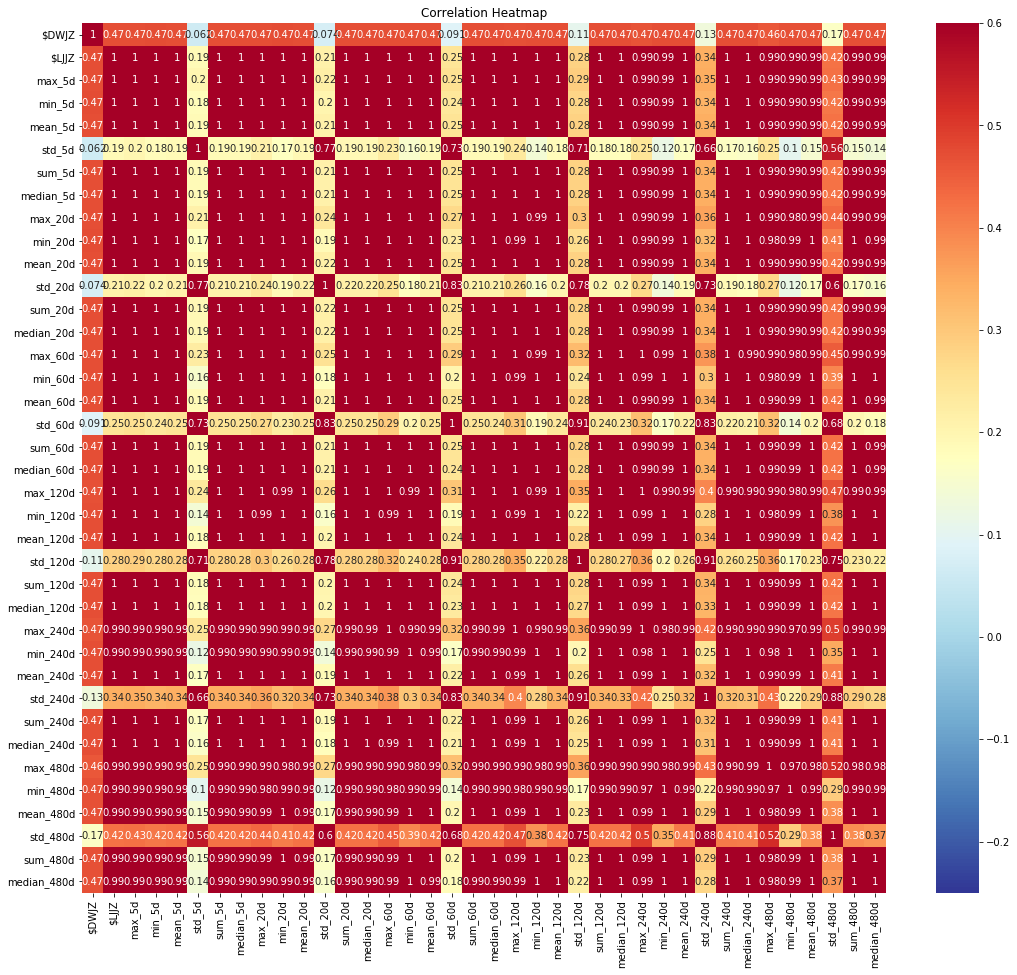

In [23]:
plt.figure(figsize = (18, 16))

# Heatmap of correlations
sns.heatmap(correlations, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [24]:
def train_predict(x_train, y_train, x_test, y_test, name = 'Model', model = 'linear' ):
    if model == 'linear':
        reg = LinearRegression()
    elif model == 'foreast':
        reg = RandomForestRegressor(criterion='mse', n_jobs=-1)
    elif model == 'lightgbm':
        reg =lgb.LGBMRegressor(objective='regression', 
                         num_leaves=4,
                         learning_rate=0.3, 
                         n_estimators=7000,
                         max_bin=300, 
                         bagging_fraction=0.75,
                         bagging_freq=5, 
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                         min_data_in_leaf=2,
                         min_sum_hessian_in_leaf=11)
    else:
        print("Modle name is invalid!")
    
    # Train on the training data
    reg.fit(x_train, y_train)

    # Make predictions
    y_pred = reg.predict(x_test)
    r2 = r2_score(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))

    print(name,": R2 is ", r2, "RMSE is ",rmse)
    print("The prediction is ",y_pred[:5],"...")
    return y_pred

1. linear regression

In [25]:
linear_pre_1d = train_predict(train,train_y_1d,test,test_y_1d,name="Linear regression model 1 day prediction", model = 'linear')

Linear regression model 1 day prediction : R2 is  -207.3695118675528 RMSE is  1.2749171396663392
The prediction is  [0.09892889 0.05631408 0.07322715 0.08543149 0.09589253] ...


In [26]:
linear_pre_5d = train_predict(train,train_y_5d,test,test_y_5d,name="Linear regression model 5 day prediction", model = 'linear')

Linear regression model 5 day prediction : R2 is  -44.16052539120828 RMSE is  2.9284146713285373
The prediction is  [0.35519638 0.32598572 0.29048671 0.40351683 0.49804693] ...


In [27]:
linear_pre_20d = train_predict(train,train_y_20d,test,test_y_20d,name="Linear regression model 20 day prediction", model = 'linear')

Linear regression model 20 day prediction : R2 is  -39.38394708903661 RMSE is  6.438357623975831
The prediction is  [1.28055325 1.30342447 1.0378784  1.31702221 1.02176913] ...


In [28]:
linear_pre_60d = train_predict(train,train_y_60d,test,test_y_60d,name="Linear regression model 60 day prediction", model = 'linear')

Linear regression model 60 day prediction : R2 is  -22.702732448808497 RMSE is  12.847269026894805
The prediction is  [1.85285218 1.63863824 1.1472007  1.13078686 0.92658368] ...


In [29]:
linear_pre_120d = train_predict(train,train_y_120d,test,test_y_120d,name="Linear regression model 120 day prediction", model = 'linear')

Linear regression model 120 day prediction : R2 is  -56.88538661469125 RMSE is  20.53682070751042
The prediction is  [4.98856149 4.73599727 4.24681109 4.48445662 4.09985079] ...


In [30]:
linear_pre_120d = train_predict(train,train_y_240d,test,test_y_240d,name="Linear regression model 240 day prediction", model = 'linear')

Linear regression model 240 day prediction : R2 is  -28.738714050711305 RMSE is  28.897826822965694
The prediction is  [16.78232513 16.27243393 15.741548   15.88698427 15.59863443] ...


2.ligthgbm

In [31]:
lightgbm_pre_1d = train_predict(train,train_y_1d,test,test_y_1d,name="lightgbm model 1 day prediction", model = 'lightgbm')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
lightgbm model 1 day prediction : R2 is  -18.494676188268713 RMSE is  1.2939835603780458
The prediction is  [0.02618517 0.02550333 0.03137638 0.04304759 0.04271971] ...


In [32]:
lightgbm_pre_5d = train_predict(train,train_y_5d,test,test_y_5d,name="lightgbm model 5 day prediction", model = 'lightgbm')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
lightgbm model 5 day prediction : R2 is  -12.068603074612334 RMSE is  2.9717625597995965
The prediction is  [0.12894328 0.1394056  0.11828777 0.38276991 0.41372159] ...


In [33]:
lightgbm_pre_20d = train_predict(train,train_y_20d,test,test_y_20d,name="lightgbm model 20 day prediction", model = 'lightgbm')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
lightgbm model 20 day prediction : R2 is  -6.998363406489558 RMSE is  6.633366486756272
The prediction is  [0.49114909 0.44266371 0.40319964 0.39631977 0.48133368] ...


In [34]:
lightgbm_pre_60d = train_predict(train,train_y_60d,test,test_y_60d,name="lightgbm model 60 day prediction", model = 'lightgbm')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
lightgbm model 60 day prediction : R2 is  -4.263236333457899 RMSE is  13.01482986189677
The prediction is  [0.15856907 0.0362985  0.03502746 0.32363105 0.34271474] ...


In [35]:
lightgbm_pre_120d = train_predict(train,train_y_120d,test,test_y_120d,name="lightgbm model 120 day prediction", model = 'lightgbm')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
lightgbm model 120 day prediction : R2 is  -5.205571399782903 RMSE is  19.905682482559257
The prediction is  [1.4258439  0.78905536 0.56988672 0.56962501 0.51483968] ...


In [36]:
lightgbm_pre_240d = train_predict(train,train_y_240d,test,test_y_240d,name="lightgbm model 240 day prediction", model = 'lightgbm')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
lightgbm model 240 day prediction : R2 is  -3.2499422595412835 RMSE is  26.749401192239908
The prediction is  [4.21606359 3.45107317 3.1931839  3.34674319 2.49512169] ...


# step4: 预测未来的样本

In [37]:
def train_predict_nolable(x_train, y_train, x_pred, name = 'Model', model = 'linear' ):
    if model == 'linear':
        reg = LinearRegression()
    elif model == 'foreast':
        reg = RandomForestRegressor(criterion='mse', n_jobs=-1)
    elif model == 'lightgbm':
        reg =lgb.LGBMRegressor(objective='regression', 
                         num_leaves=4,
                         learning_rate=0.3, 
                         n_estimators=7000,
                         max_bin=300, 
                         bagging_fraction=0.75,
                         bagging_freq=5, 
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                         min_data_in_leaf=2,
                         min_sum_hessian_in_leaf=11)
    else:
        print("Modle name is invalid!")
    
    # Train on the training data
    reg.fit(x_train, y_train)

    # Make predictions
    y_pred = reg.predict(x_pred)

    print("The prediction is ",y_pred[:5],"...")
    return y_pred

In [38]:
df_pre = df_no_label[df_no_label['datetime'] == '2021-04-30']
df_pre = df_pre.drop(columns = ['datetime'])
no_label = scaler.transform(df_pre)
print('Nolabel data shape: ', no_label.shape)

Nolabel data shape:  (5755, 39)


In [39]:
train.shape

(3554735, 39)

In [40]:
df_pre.shape

(5755, 39)

In [41]:
y_pred = train_predict_nolable(train, train_y_1d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_1d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_pre, df, how = 'inner', left_index=True, right_index=True) 

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
The prediction is  [-0.03197476 -0.03189286 -0.01864916  0.34743766 -0.05328096] ...


In [42]:
y_pred = train_predict_nolable(train, train_y_5d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_5d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
The prediction is  [-0.12226227 -0.2857754  -0.27204553  0.13381809 -0.23632849] ...


In [43]:
y_pred = train_predict_nolable(train, train_y_20d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_20d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
The prediction is  [ 1.50102754 -1.42788808 -1.1304584   2.49809968 -1.38475228] ...


In [44]:
y_pred = train_predict_nolable(train, train_y_60d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_60d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
The prediction is  [ -3.83233895 -10.31909792  -9.34088349  -0.94706798  -2.41884924] ...


In [45]:
y_pred = train_predict_nolable(train, train_y_120d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_120d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
The prediction is  [-7.32975174 -9.61238172 -9.91355583 -3.06406378  1.3585931 ] ...


In [46]:
y_pred = train_predict_nolable(train, train_y_240d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_240d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
The prediction is  [-0.7977623  26.84611281 25.66275351 -3.65216092 -2.69430928] ...


In [47]:
df_result = df_result[['instrument','pred_1d','pred_5d','pred_20d','pred_60d','pred_120d','pred_240d']]

In [48]:
df_result[df_result['instrument']=='502056']

,instrument,pred_1d,pred_5d,pred_20d,pred_60d,pred_120d,pred_240d


| 基金名称 | 基金号码  | 持仓金额 | 成本 
| :-----| ----: | :----: | :----: |
| 中欧医疗健康混合C | 003096 | 5521 | 5000
| 中欧时代先锋股票A | 001938 | 335 |
| 广发多因子混合 | 002943 | 6147 |
| 广发纳斯达克100指数A | 270042 | 3065 | 3000
| 广发中证医疗指数(LOF)A | 502056 | 1000 | 1000
| 广发高端制造股票A( | 004997 | 1946 | 2000
| 景顺长城鼎益混合(LOF) | 162605 | 3175 | 3000
| 景顺长城新兴成长混合 | 260108 | 2719 | 2740
| 景顺长城优选混合 | 260101 | 2019 |
| 国富弹性市值混合 | 450002 | 13380 |
| 银华富裕主题混合 | 180012 | 2251 |
| 南方优选成长混合A | 202023 | 1022 |
| 南方中证全指证券公司ETF联接C | 004070 | 391 | 400
| 兴全合润混合(LOF) | 163406 | 4000 | 4000
| 兴全合宜混合(LOF)A | 163417 | 2034 |
| 兴全趋势投资混合(LOF) | 163402 | 1031 |
| 大成高新技术产业股票A | 00628 | 991 | 1000
| 大成新锐产业混合 | 090018 | 1006 | 1000
| 天弘中证500指数增强C | 001557 | 1000 | 1000
| 天弘中证银行ETF联接C | 001595 | 966 | 1000
| 工银战略远见混合C | 011933 | 1000 | 1000
| 方正富邦保险主题指数 | 167301 | 191 | 200
| 华夏中证500ETF联接A | 001052 | 1043 |
| 嘉实智能汽车股票 | 002168 | 1045 | 1000
| 信达澳银新能源产业股票 | 001410 | 672 |





In [49]:
df_result[df_result['instrument']=='450002']

,instrument,pred_1d,pred_5d,pred_20d,pred_60d,pred_120d,pred_240d


In [50]:
df_result.to_csv('20210430.csv')